In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Finite case
$x\in[M]$

In [3]:
M = 1000

### True function

In [4]:
_d = 10
param = np.random.uniform(size=_d) - 1/2
fmap = np.array([[(x/M)**y for y in range(_d)] for x in range(M)])
#fmap = np.random.uniform(size = (M, _d))
_f = np.matmul(fmap, param)
f = lambda x: _f[x]

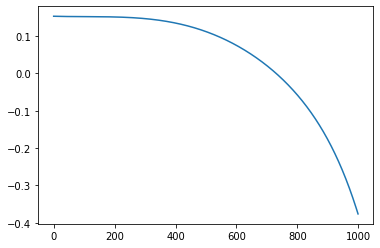

In [5]:
plt.plot(range(M), _f)

In [6]:
ylim = [min(_f)-0.1, max(_f)+0.1]

### Approximation with d random features (no noise)

In [7]:
def rfmap(d):
    return np.random.normal(size=(M,d))

In [8]:
def ols(X, y, reg=0):
    A = np.matmul(X.T,X) + reg * np.eye(d)
    b = np.matmul(X.T, y)
    theta = np.linalg.solve(A,b)
    return np.matmul(X, theta), theta

In [9]:
RF = rfmap(M)
err = np.zeros(M)
perr = np.zeros(M)
fhats = np.zeros((M,M))
for d in range(1, M+1):
    X = RF[:, :d] 
    y = _f
    fhat, theta = ols(X, y)
    fhats[d-1] = fhat
    err[d-1] = np.linalg.norm(fhat - _f, ord=1) / M
    

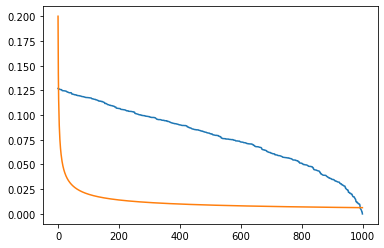

In [10]:
plt.plot(range(M), err)
plt.plot(range(M), 0.2/np.sqrt(range(1,M+1)))

In [11]:
xx = range(M)

def update(d = 1):
    plt.plot(xx, _f, xx, fhats[d-1])
    axes = plt.gca()
    axes.set_ylim(ylim)
    
slider = widgets.interact(update, d=widgets.IntSlider(min=1, max=M, step=1, value=1))

interactive(children=(IntSlider(value=1, description='d', max=1000, min=1), Output()), _dom_classes=('widget-i…

### With noise

In [12]:
N = 900
noise = 0.001
reg = 1
S = np.random.choice(M, size=N, replace=True)
y = _f[S] + noise * np.random.normal(size=N)

In [13]:
RF = rfmap(M)
err = np.zeros(M)
fhats = np.zeros((M,M))
for d in range(1, M+1):
    X = RF[S, :d] 
    fhat, theta = ols(X, y, reg)
    err[d-1] = np.linalg.norm(np.matmul(RF[:, :d], theta) - _f, ord=1) / N
    fhats[d-1] = np.matmul(RF[:, :d], theta)

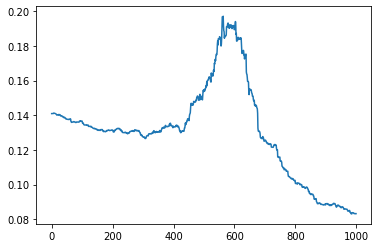

In [14]:
plt.plot(range(M), err)

In [15]:
xx = range(M)

def update(d = 1):
    plt.scatter(S,y)
    plt.plot(xx, fhats[d-1])
    axes = plt.gca()
    axes.set_ylim(ylim)
    
slider = widgets.interact(update, d=widgets.IntSlider(min=1, max=M, step=1, value=M))

interactive(children=(IntSlider(value=1000, description='d', max=1000, min=1), Output()), _dom_classes=('widge…

# Linear case

$x\in\mathbb{R}^m$

In [16]:
def make_fun(m):
    param = 2 * np.random.uniform(size=m) - 1
    return lambda x : np.matmul(x, param)

In [17]:
#This represents functions of the form <x,c> + d
def make_rfm(d, m):
    A = np.random.normal(size=(d, m))
    b = np.random.normal(size=d)
    return lambda X: np.matmul(A, X.T).T + b

In [18]:
def ls(A, b, reg=0):
    return np.linalg.solve(np.matmul(A.T, A) + reg * np.eye(A.shape[-1]), np.matmul(A.T, b))

In [19]:
def rf_approx(X, y, d, reg=0):
    rfm = make_rfm(d, X.shape[-1])
    Phi = rfm(X) #Nxd
    theta = ls(Phi, y, reg)
    yhat = np.matmul(Phi, theta)
    return yhat, rfm, theta

In [20]:
def gen_rank(n, m, r):
    A = 2 * np.random.uniform(size=(n, r)) - 1
    B = 2 * np.random.uniform(size=(r, r)) - 1
    C = 2 * np.random.uniform(size=(r, m)) - 1
    M = np.matmul(np.matmul(A, B), C)
    assert np.linalg.matrix_rank(M) == r
    return M

### Scalar example

(-1.0, 1.0)

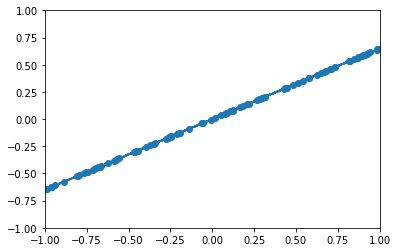

In [21]:
m = 1
N = 100
noise = 0
d = 2

f = make_fun(m)
X = 2 * np.random.uniform(size=(N, m)) - 1
y = f(X) + noise * np.random.normal(size=N)
yhat, _, _ = rf_approx(X, y, d)
xx = np.linspace(-1,1,100)
plt.scatter(X, y)
plt.plot(X, yhat)
ax = plt.gca()
ax.set_ylim([-1,1])
ax.set_xlim([-1,1])

### Full-rank case

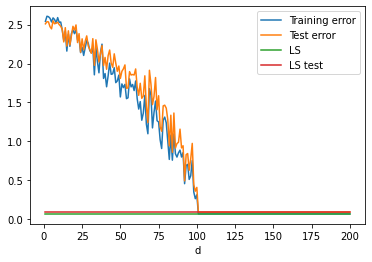

In [22]:
m = 100
N = 500
noise = 0.1
reg = 0
norm_ord = 1
max_d = 2 * m

f = make_fun(m)
X = 2 * np.random.uniform(size=(N, m)) - 1
y = f(X) + noise * np.random.normal(size=N)
ls_param = ls(X, y, reg)
yls = np.matmul(X, ls_param)
lserr = np.linalg.norm(yls - y, ord=norm_ord)**norm_ord / N
lsrank = np.linalg.matrix_rank(X)

X_test = 2 * np.random.uniform(size=(N, m)) - 1
y_test = f(X_test) + noise * np.random.normal(size=N)
yls_test = np.matmul(X_test, ls_param)
test_lserr = np.linalg.norm(yls_test - y_test, ord=norm_ord)**norm_ord / N

err = []
test_err = []
ranks = []
for d in range(1, max_d+1):
    yhat, rfm, theta = rf_approx(X, y, d, reg)
    err.append(np.linalg.norm(y - yhat, ord=norm_ord)**norm_ord / N)
    ranks.append(np.linalg.matrix_rank(rfm(X)))
    
    #Test
    yhat_test = np.matmul(rfm(X_test), theta)
    test_err.append(np.linalg.norm(y_test - yhat_test, ord=norm_ord)**norm_ord / N)

xx = range(1, max_d+1)
plt.plot(xx, err)
plt.plot(xx, test_err)
plt.plot([xx[0], xx[-1]], [lserr, lserr])
plt.plot([xx[0], xx[-1]], [test_lserr, test_lserr])
plt.xlabel('d')
plt.legend(('Training error', 'Test error', 'LS', 'LS test'))

(0.0, 0.7531784719329361)

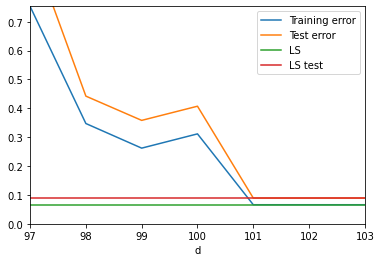

In [23]:
xx = range(1, max_d+1)
plt.plot(xx, err)
plt.plot(xx, test_err)
plt.plot([xx[0], xx[-1]], [lserr, lserr])
plt.plot([xx[0], xx[-1]], [test_lserr, test_lserr])
plt.xlabel('d')
plt.legend(('Training error', 'Test error', 'LS', 'LS test'))
plt.gca().set_xlim((m-3, m+3))
plt.gca().set_ylim((0,err[m-4]))

100 101


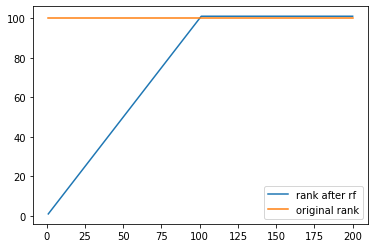

In [24]:
print(lsrank, np.max(ranks))
plt.plot(xx, ranks)
plt.plot((xx[0], xx[-1]),(lsrank, lsrank))
plt.legend(('rank after rf', 'original rank'))

In [25]:
for i in range(max_d): print(i+1, err[i], test_err[i], '\n')

1 2.5426090513013233 2.51015183619977 

2 2.60777656621826 2.5375418934924525 

3 2.601990181125333 2.534734386074181 

4 2.5820872690562253 2.4733022798246327 

5 2.534570603891234 2.4457712058757455 

6 2.586717892548279 2.5492463658880973 

7 2.564957419345781 2.510650152544023 

8 2.522143833926293 2.5196109908684523 

9 2.5904961777722884 2.5306079762917992 

10 2.529601615612291 2.5004743256869166 

11 2.53351106543031 2.4792107811775144 

12 2.4318029692604695 2.440126581093247 

13 2.2951891478948747 2.277299771660624 

14 2.4138137591729034 2.4607583847126966 

15 2.159665951183665 2.223581576601495 

16 2.3762011678938735 2.420343114331462 

17 2.2210617519411424 2.23759737937651 

18 2.3856501164866724 2.3597342606967455 

19 2.4324477451216944 2.478344084545415 

20 2.3836261194487722 2.429483214831107 

21 2.434468214549881 2.4960018615472492 

22 2.301125952607299 2.2692998472859545 

23 2.3195235377387244 2.384117417686379 

24 2.140124473943531 2.1455192453199756 

25 2

### The rank-deficient case

93

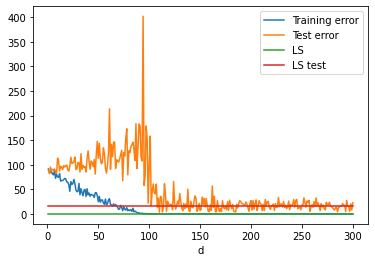

In [26]:
m = 100
N = 1000
noise = 0.1
reg = 0.1
norm_ord = 1
max_d = 3*m
rank = m - 1

f = make_fun(m)

#Contexts do not span R^d
X = gen_rank(N, m, rank)
lsrank = np.linalg.matrix_rank(X)

y = f(X) + noise * np.random.normal(size=N)
ls_param = ls(X, y, reg)
yls = np.matmul(X, ls_param)
lserr = np.linalg.norm(yls - y, ord=norm_ord)**norm_ord / N

X_test = gen_rank(N, m, rank)
y_test = f(X_test) + noise * np.random.normal(size=N)
yls_test = np.matmul(X_test, ls_param)
test_lserr = np.linalg.norm(yls_test - y_test, ord=norm_ord)**norm_ord / N

err = []
test_err = []
ranks = []
for d in range(1, max_d+1):
    yhat, rfm, theta = rf_approx(X, y, d, reg)
    err.append(np.linalg.norm(y - yhat, ord=norm_ord)**norm_ord / N)
    #print(rfm(X).shape)
    ranks.append(np.linalg.matrix_rank(rfm(X)))
    
    #Test
    yhat_test = np.matmul(rfm(X_test), theta)
    test_err.append(np.linalg.norm(y_test - yhat_test, ord=norm_ord)**norm_ord / N)

xx = range(1, max_d+1)
plt.plot(xx, err)
plt.plot(xx, test_err)
plt.plot([xx[0], xx[-1]], [lserr, lserr])
plt.plot([xx[0], xx[-1]], [test_lserr, test_lserr])
plt.xlabel('d')
plt.legend(('Training error', 'Test error', 'LS', 'LS test'))
np.argmax(test_err)

99 100


Text(0.5, 0, 'd')

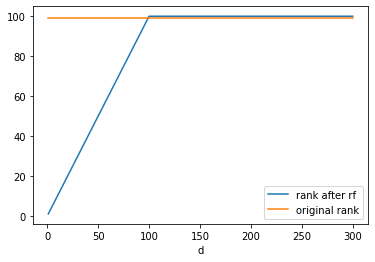

In [27]:
print(lsrank, np.max(ranks))
plt.plot(xx, ranks)
plt.plot((xx[0], xx[-1]),(lsrank, lsrank))
plt.legend(('rank after rf', 'original rank'))
plt.xlabel('d')

### Playing with perturbed matrices

1000
2
RFN:
1/1000
19/1000
1000/1000


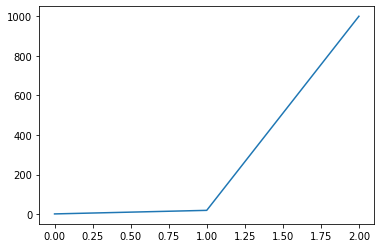

In [31]:
n = 1000
m = n
r = 1
A = gen_rank(n,m,r)
std = 1

B = A + np.random.normal(size=(n, m), scale=std)
print(np.linalg.matrix_rank(B))

C = A + np.random.normal(size=m, scale=std)
print(np.linalg.matrix_rank(C))


print('RFN:')
D = A
rank = np.linalg.matrix_rank(D)
ranks = [rank]
print('%d/%d' % (rank, min(m, n)))
max_layers = 100
activation = np.cos
#activation = lambda X: np.maximum(X, 0)
#activation = lambda X: X**2 / np.linalg.norm(X**2, 2)
#activation = lambda X: 0.01 * X**2
while(np.linalg.matrix_rank(D) < min(n, m) and len(ranks) < max_layers):
    W = np.random.normal(size=(n,n), scale=std)
    b = np.random.normal(size=m, scale=std)
    D = np.matmul(W, D) + b
    D = activation(D)
    rank = np.linalg.matrix_rank(D)
    ranks.append(rank)
    print('%d/%d' % (rank, min(m, n)))
plt.plot(range(len(ranks)), ranks)